In [7]:
import tensorflow as tf
import warnings
# Suppress TensorFlow deprecation warnings
tf.get_logger().setLevel('ERROR')
# Suppress general Python warnings (optional but helpful)
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report


# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12

In [8]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.python.client import device_lib

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices("GPU"))
print("\nDevice List:")
print(device_lib.list_local_devices())


TensorFlow version: 2.15.0
Available GPUs: []

Device List:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11148300078881925809
xla_global_id: -1
]


In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === SET PATH ===
dataset_path = "./data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
output_dir = "./split_dataset"
os.makedirs(output_dir, exist_ok=True)

# === CREATING TRAIN, VALIDATION, TEST SPLIT ===
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split dataset: 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [10]:
print("Unique labels:", df["label"].unique())

Unique labels: ['Cyst' 'Normal' 'Stone' 'Tumor']


In [11]:
# === IMAGE DATA GENERATORS WITH AUGMENTATION ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    rotation_range=20,        # Random rotation (0-20 degrees)
    width_shift_range=0.2,    # Random width shift (20% of width)
    height_shift_range=0.2,   # Random height shift (20% of height)
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for val/test

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

Found 7467 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


In [12]:
def show_images(path,title,cmap=None):
    labels = list(os.listdir(path))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    random_indices = random.sample(range(1, 101), 10)

    for i, idx in enumerate(random_indices, 1):
        file_path = os.path.join(path, labels[idx])
        image = Image.open(file_path)
        subplot_row = (i - 1) // 5
        subplot_col = (i - 1) % 5
        axes[subplot_row, subplot_col].imshow(image, cmap=cmap)
        axes[subplot_row, subplot_col].axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

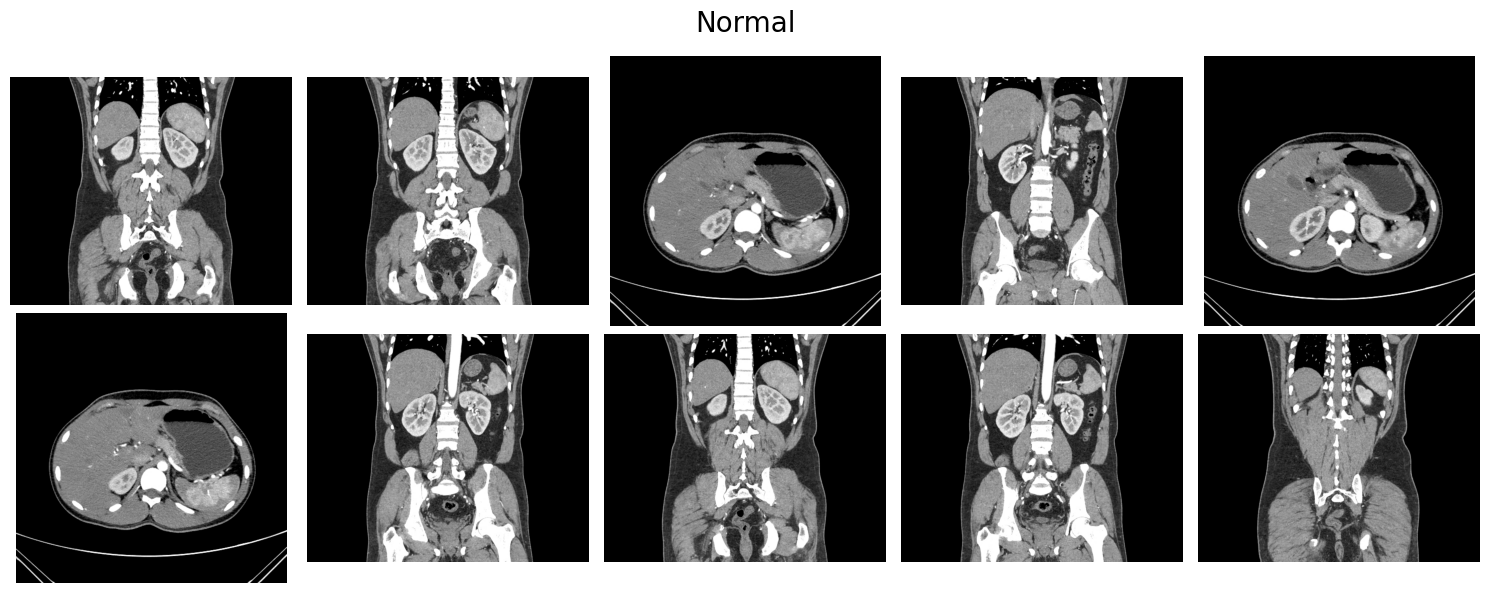

In [13]:
# Healthy Kidney
show_images(os.path.join(dataset_path+"/Normal"),"Normal")

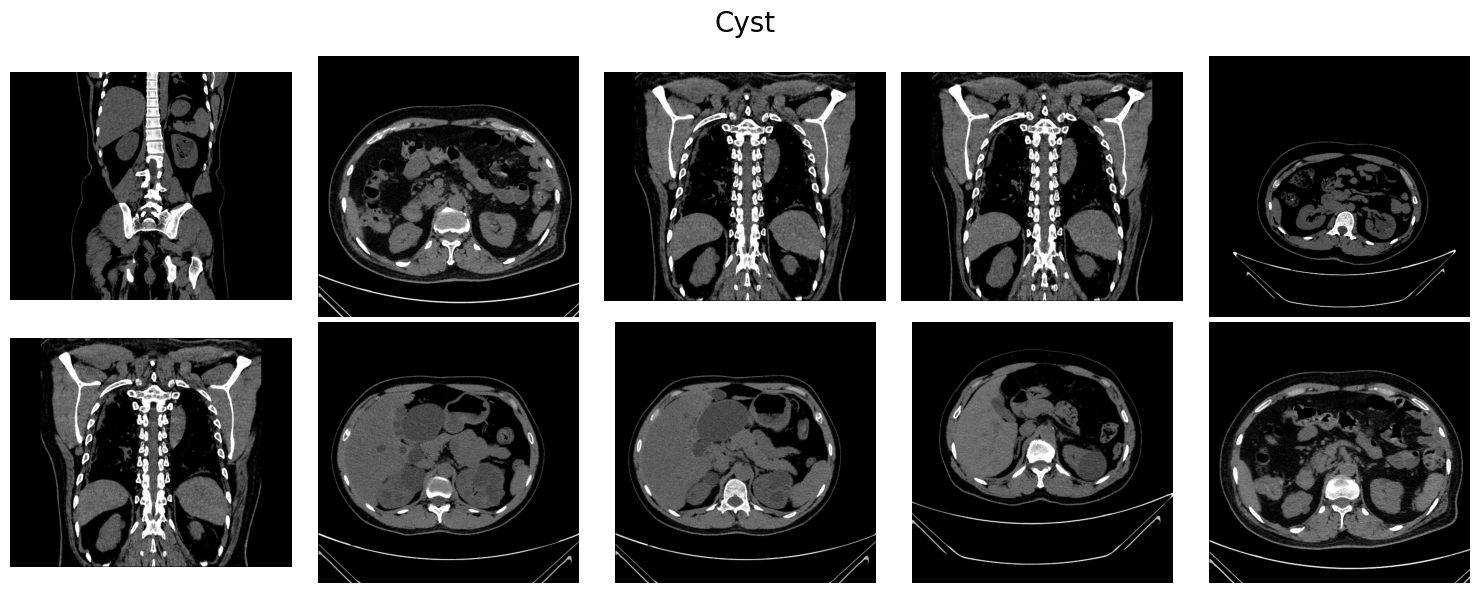

In [14]:
# Cyst
show_images(os.path.join(dataset_path+"/Cyst"),"Cyst")

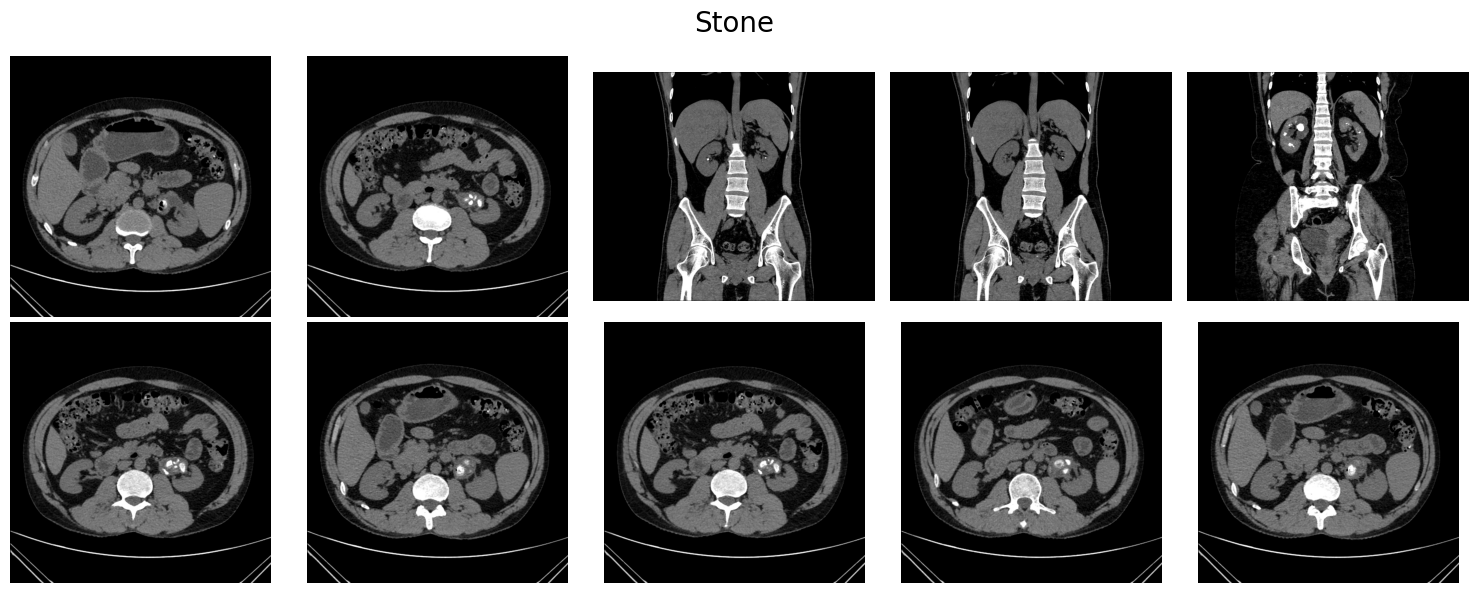

In [15]:
# Stone
show_images(os.path.join(dataset_path+"/Stone"),"Stone")


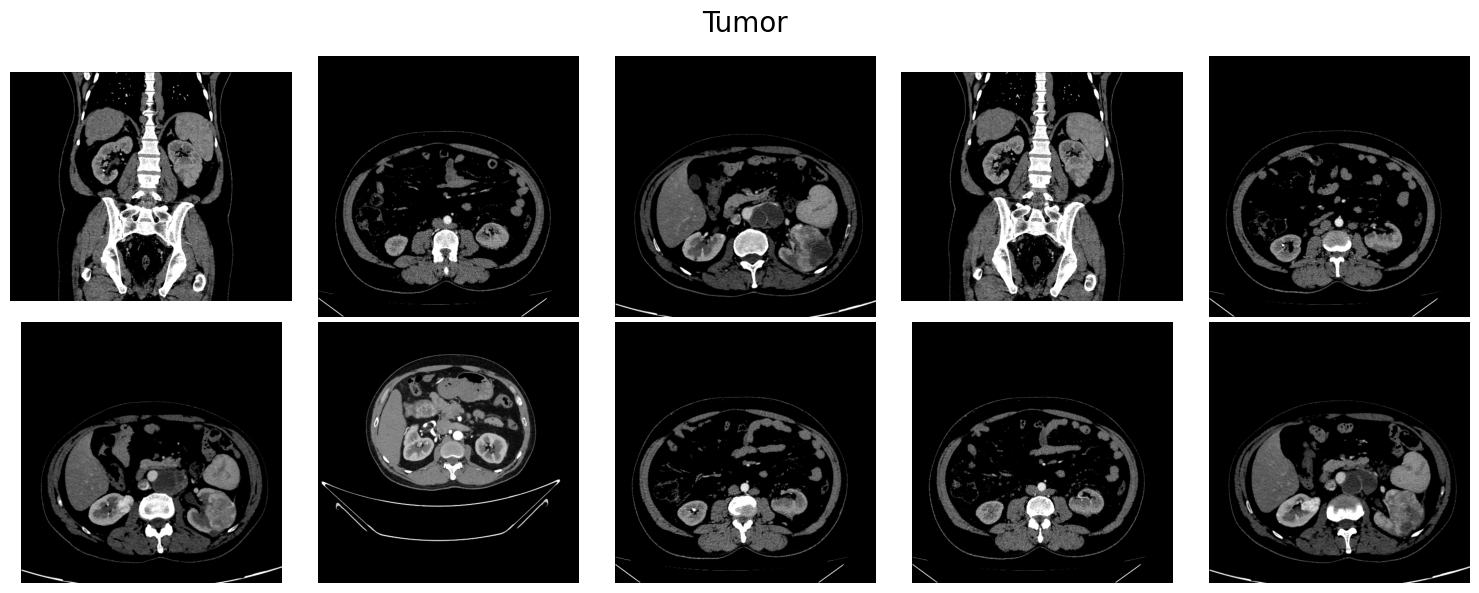

In [16]:
# Tumor
show_images(os.path.join(dataset_path+"/Tumor"),"Tumor")

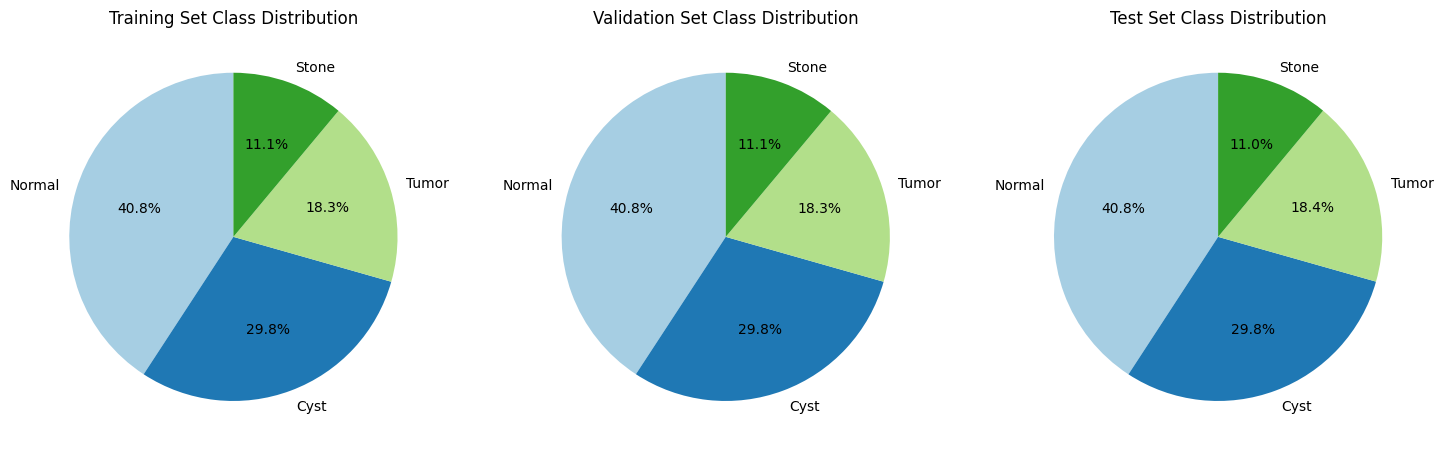

In [18]:
# === PLOT CLASS DISTRIBUTION ===
def plot_class_distribution(df, title, subplot_idx):
    class_counts = df["label"].value_counts()
    plt.subplot(1, 3, subplot_idx)
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)

plt.figure(figsize=(18, 6))
plot_class_distribution(train_df, "Training Set Class Distribution", 1)
plot_class_distribution(val_df, "Validation Set Class Distribution", 2)
plot_class_distribution(test_df, "Test Set Class Distribution", 3)
plt.show()

Training Set Class Distribution After Oversampling:
label
Tumor     3046
Normal    3046
Cyst      3046
Stone     3046
Name: count, dtype: int64

Validation Set Class Distribution After Oversampling:
label
Cyst      1015
Normal    1015
Tumor     1015
Stone     1015
Name: count, dtype: int64

Test Set Class Distribution After Oversampling:
label
Normal    1016
Stone     1016
Tumor     1016
Cyst      1016
Name: count, dtype: int64


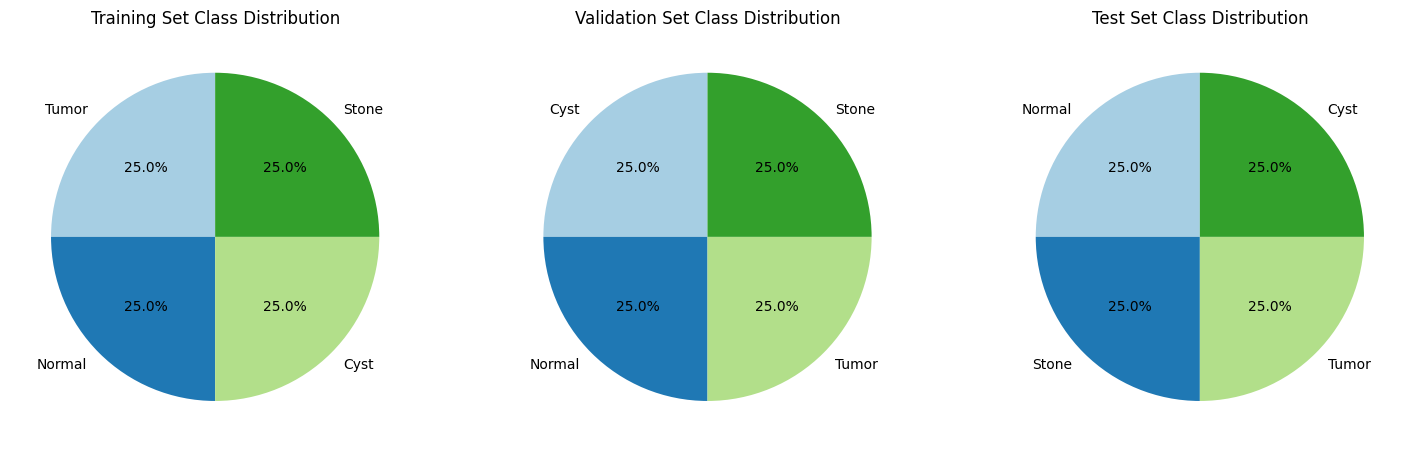

In [20]:
import pandas as pd
import numpy as np

# Function to manually oversample all classes equally
def oversample_data(df):
    # Get the counts of each class
    class_counts = df['label'].value_counts()
    
    # Find the max class count (which is the majority class, e.g. 'Normal' or 'Cyst')
    max_class_count = class_counts.max()
    
    # Separate the data by class
    tumor_df = df[df['label'] == 'Tumor']
    stone_df = df[df['label'] == 'Stone']
    normal_df = df[df['label'] == 'Normal']
    cyst_df = df[df['label'] == 'Cyst']
    
    # Oversample all classes to match the max class count
    tumor_resampled = tumor_df.sample(n=max_class_count, replace=True, random_state=42)
    stone_resampled = stone_df.sample(n=max_class_count, replace=True, random_state=42)
    normal_resampled = normal_df.sample(n=max_class_count, replace=True, random_state=42)
    cyst_resampled = cyst_df.sample(n=max_class_count, replace=True, random_state=42)
    
    # Combine the resampled data
    df_balanced = pd.concat([tumor_resampled, stone_resampled, normal_resampled, cyst_resampled])
    
    # Shuffle the dataset (optional)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_balanced

# Apply the manual oversampling to training, validation, and test datasets
train_df_balanced = oversample_data(train_df)
val_df_balanced = oversample_data(val_df)
test_df_balanced = oversample_data(test_df)

# Check the class distribution after oversampling
print("Training Set Class Distribution After Oversampling:")
print(train_df_balanced['label'].value_counts())
print("\nValidation Set Class Distribution After Oversampling:")
print(val_df_balanced['label'].value_counts())
print("\nTest Set Class Distribution After Oversampling:")
print(test_df_balanced['label'].value_counts())

# Plot the new class distribution
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(df, title, subplot_idx):
    class_counts = df['label'].value_counts()
    plt.subplot(1, 3, subplot_idx)
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)

# Plot after oversampling
plt.figure(figsize=(18, 6))
plot_class_distribution(train_df_balanced, "Training Set Class Distribution", 1)
plot_class_distribution(val_df_balanced, "Validation Set Class Distribution", 2)
plot_class_distribution(test_df_balanced, "Test Set Class Distribution", 3)
plt.show()

In [21]:
# === LOAD RESNET50 MODEL ===
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# === FREEZE BASE LAYERS ===
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially

# === ADD CUSTOM LAYERS ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(len(df["label"].unique()), activation="softmax")(x)  # Output layer with # of classes

# === CREATE FINAL MODEL ===
model = Model(inputs=base_model.input, outputs=x)

In [22]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_recall', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_recall', patience = 5)

In [23]:
# === COMPILE MODEL ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [24]:
# === TRAIN MODEL ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks = [lr_callback, stop_callback]
)

Epoch 1/12
234/234 [==============================] - 395s 2s/step - loss: 0.7524 - accuracy: 0.7105 - precision: 0.8097 - recall: 0.5834 - val_loss: 0.5066 - val_accuracy: 0.8067 - val_precision: 0.8430 - val_recall: 0.7553 - lr: 1.0000e-04
Epoch 2/12
234/234 [==============================] - 406s 2s/step - loss: 0.4163 - accuracy: 0.8492 - precision: 0.8805 - recall: 0.8140 - val_loss: 0.3715 - val_accuracy: 0.8710 - val_precision: 0.8923 - val_recall: 0.8521 - lr: 1.0000e-04
Epoch 3/12
234/234 [==============================] - 430s 2s/step - loss: 0.3167 - accuracy: 0.8879 - precision: 0.9070 - recall: 0.8698 - val_loss: 0.3104 - val_accuracy: 0.8867 - val_precision: 0.9014 - val_recall: 0.8738 - lr: 1.0000e-04
Epoch 4/12
234/234 [==============================] - 524s 2s/step - loss: 0.2466 - accuracy: 0.9130 - precision: 0.9261 - recall: 0.9012 - val_loss: 0.3081 - val_accuracy: 0.8811 - val_precision: 0.8964 - val_recall: 0.8694 - lr: 1.0000e-04
Epoch 5/12
234/234 [============

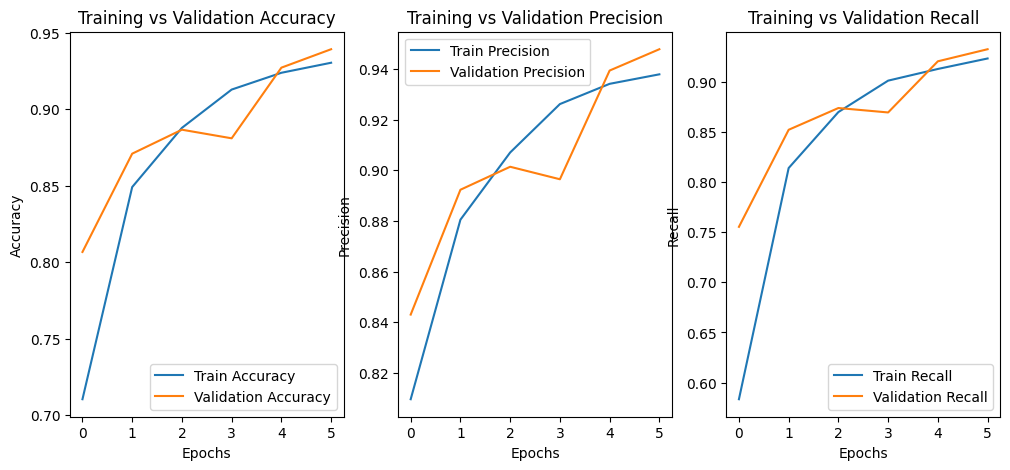

In [25]:
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Precision plot
plt.subplot(1, 3, 2)
plt.plot(history.history["precision"], label="Train Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Training vs Validation Precision")

# Recall plot
plt.subplot(1, 3, 3)
plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Training vs Validation Recall")

plt.show()

In [26]:
# === EVALUATE MODEL ON TEST DATA ===
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

78/78 [==============================] - 100s 1s/step - loss: 0.1621 - accuracy: 0.9482 - precision: 0.9524 - recall: 0.9406
Test Accuracy: 0.9482
Test Precision: 0.9524
Test Recall: 0.9406


In [27]:
# === CLASSIFICATION REPORT ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

78/78 [==============================] - 100s 1s/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.93      0.99      0.96       742
      Normal       0.96      0.96      0.96      1016
       Stone       0.90      0.81      0.85       275
       Tumor       0.97      0.93      0.95       457

    accuracy                           0.95      2490
   macro avg       0.94      0.92      0.93      2490
weighted avg       0.95      0.95      0.95      2490



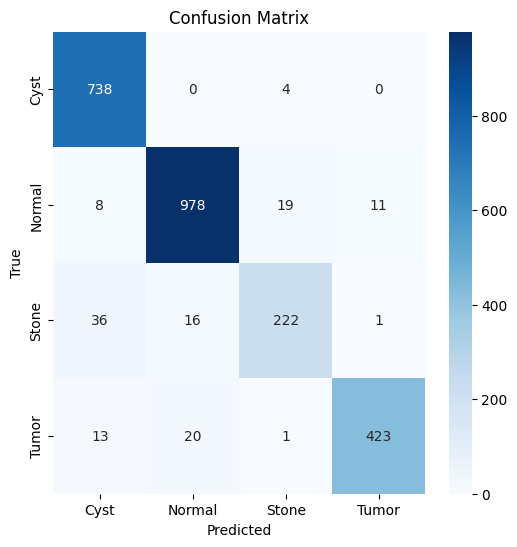

In [29]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# === SAVE MODEL ===
model.save('my_model.keras')

1/1 [==============================] - 1s 1s/step


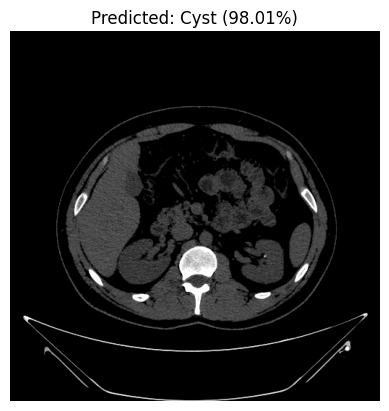

In [ ]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input


# === UPLOAD GAMBAR ===
uploaded = {"cyst.jpg":"cyst.jpg"}  # manually list your test image filename

# === LOAD MODEL (format .keras) ===
model = load_model("my_model.keras")  # Sesuaikan path model

# === URUTAN KELAS (sesuai saat training) ===
class_names = class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Hasilnya: ['Cyst', 'Normal', 'Stone', 'Tumor'] atau sesuai isi folder

# === PREDIKSI SETIAP GAMBAR YANG DIUPLOAD ===
for filename in uploaded.keys():
    # Baca gambar dan ubah ke ukuran ResNet50
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))  # ResNet50 input
    img_array = preprocess_input(np.expand_dims(img_resized, axis=0))

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Tampilkan hasil prediksi
    plt.imshow(img_rgb)
    confidence = np.max(prediction) * 100
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()